# Goal
Now that we have successfully processed both the files, we must prepare them for an AWESOME predictive model that will:

1. Help the organization to predict which loans may prove to be Risky.
2. Tell us what are the top features that influence such Risky loans.
3. Help the organization prepare a strategy that will minimize the risk of loss due to such bad loans

In [114]:
# Loading required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import auc, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler, label_binarize
import seaborn as sns

from sklearn.model_selection import GridSearchCV

import gc

%matplotlib inline
sns.set(style='whitegrid', palette='inferno', font_scale=1.5)

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
data = pd.read_csv("cmpnydata/final_data.csv")
data.drop(['Unnamed: 0'],axis=1,inplace=True)

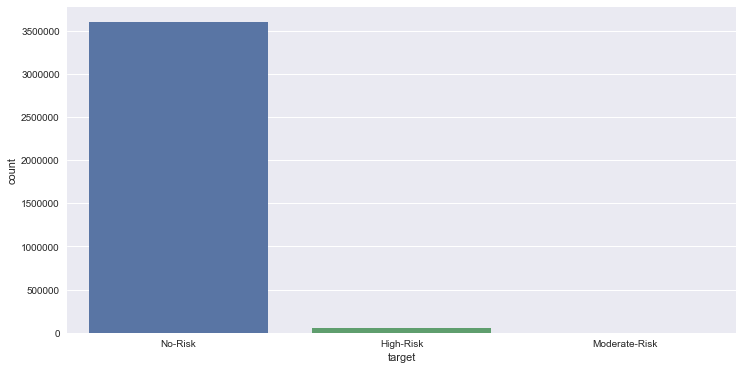

In [7]:
sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(data['target'])

**It is clear that the dataset is highly unbalanced and we will have to use a suitable Sampling technique to tackle this problem**

In [4]:
data['target'] = data['target'].map({'No-Risk':1, 'Moderate-Risk':2, 'High-Risk':3})

In [21]:
data.columns

Index(['target', 'loanID', 'origChannel', 'sellerName', 'origIntRate',
       'orgUPB', 'orgLoanTerm', 'orginationDate', 'firstPaymentDate', 'orgLTV',
       'orgCombinedLTV', 'numBorrowers', 'orgDebttoIncomeRatio',
       'borrowerCreditScoreAtOrigination', 'firstTimeHomeBuyer', 'loanPurpose',
       'propType', 'numUnits', 'occType', 'propertyState', 'zipCodeShort',
       'priMortgageInsurancePercent', 'prodType',
       'coBorrowerCreditScoreAtOrigination', 'mortInsType',
       'reloMortIndicator', 'currIntRate', 'zeroBalCode', 'zeroBalEffDate',
       'lastPaidInstallmentDate', 'currActualUPB', 'loanAge',
       'remainingMonthsToLegalMaturity', 'adjustedMonthsToMaturity',
       'maturityDate', 'msa', 'currLoanDelinquencyStatus', 'modFlag',
       'foreclosureDate', 'dispositionDate', 'foreclosureCosts',
       'otherForeclosureProceeds', 'nonInterestBearingUPB',
       'foreclosurePrincipalWriteOffAmt'],
      dtype='object')

In [5]:
colstodrop = ['foreclosureDate', 'currLoanDelinquencyStatus', 'foreclosureCosts', 'otherForeclosureProceeds',
              'zeroBalCode', 'zeroBalEffDate', 'otherForeclosureProceeds', 'foreclosurePrincipalWriteOffAmt']

In [6]:
final_data = data.drop(columns=colstodrop,axis=1)

**Lets have a look at how our data features are correlated with each other**

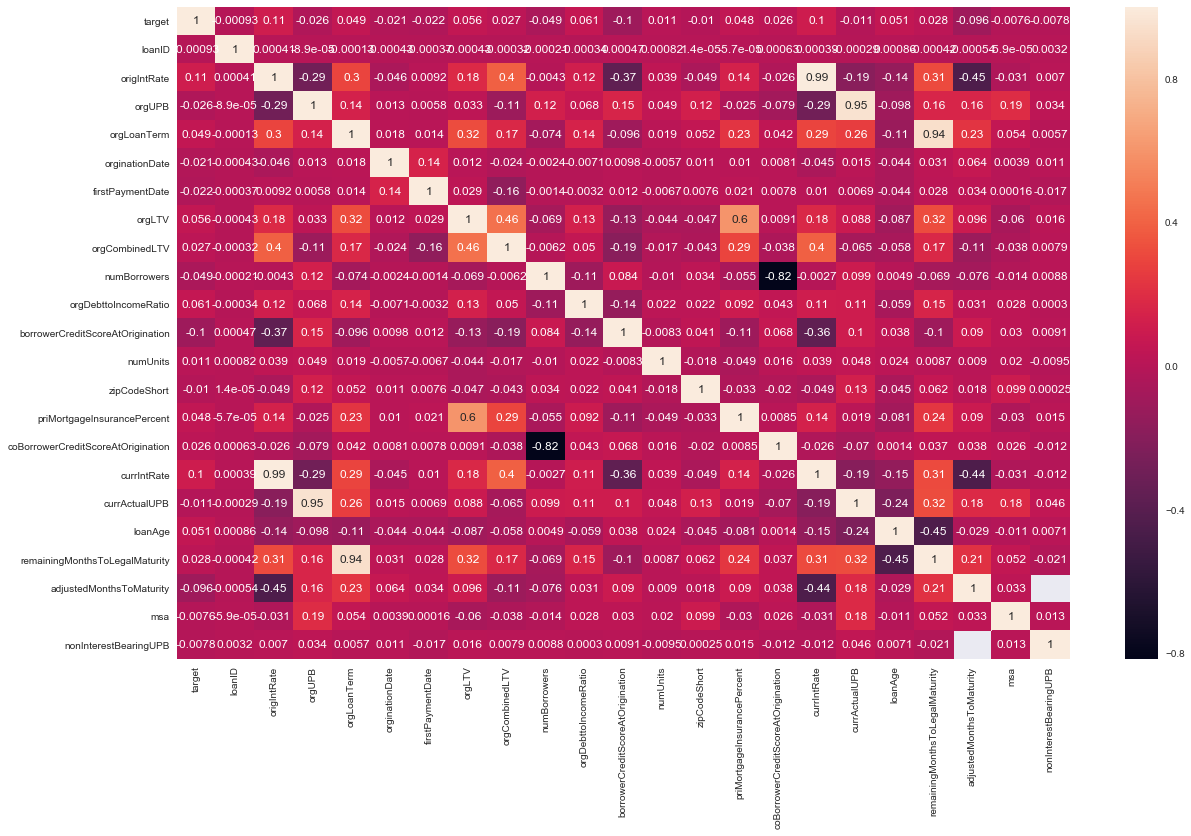

In [26]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(final_data.corr(),annot=True)

In [45]:
gc.collect()

10344

In [8]:
nulls = pd.DataFrame(round(final_data.isnull().sum()/len(final_data.index)*100,5),columns=['null_percent'])
#sns.barplot(x='index',y='null_percent',data=nulls.reset_index())
nulls[nulls['null_percent']!=0.00].sort_values('null_percent',ascending=False)

,null_percent
nonInterestBearingUPB,99.74845
dispositionDate,98.82522
lastPaidInstallmentDate,98.80557
adjustedMonthsToMaturity,0.25713
remainingMonthsToLegalMaturity,0.00553
maturityDate,0.00553
currActualUPB,0.00156


In [9]:
# We don't want to use features which have ~99% missing values

drop_cols = nulls[nulls['null_percent']>75.0].index
final_data.drop(drop_cols, axis=1, inplace=True)

In [38]:
final_data.head()

,target,loanID,origChannel,sellerName,origIntRate,orgUPB,orgLoanTerm,orginationDate,firstPaymentDate,orgLTV,...,mortInsType,reloMortIndicator,currIntRate,currActualUPB,loanAge,remainingMonthsToLegalMaturity,adjustedMonthsToMaturity,maturityDate,msa,modFlag
0,1,100007365142,R,JPMORGAN CHASE BANK NA,8.000,75000,360,121999,22000,79.0,...,None,N,8.000,72564.61,39,321.0,0.0,01/2030,0,N
1,1,100007386460,B,JPMORGAN CHASE BANK NA,7.875,55000,180,12000,32000,69.0,...,None,N,7.875,52830.25,15,165.0,0.0,02/2015,47900,N
2,1,100023274028,R,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,8.000,130000,360,12000,32000,61.0,...,None,N,8.000,127430.15,31,329.0,0.0,02/2030,12060,N
3,1,100026859568,C,FIRST TENNESSEE BANK NATIONAL ASSOCIATION,8.375,107000,360,22000,42000,95.0,...,1.0,N,8.375,104227.18,35,325.0,0.0,03/2030,41180,N
4,1,100028993931,R,WELLS FARGO BANK N.A.,8.000,37000,180,22000,42000,63.0,...,None,N,8.000,37000.00,4,176.0,0.0,03/2015,25860,N


In [10]:
final_data['currActualUPB'].fillna(1000,inplace=True)
final_data['adjustedMonthsToMaturity'].fillna(final_data['remainingMonthsToLegalMaturity'],inplace=True)

In [11]:
nulls = pd.DataFrame(final_data.isnull().sum(),columns=['nulls'])
#sns.barplot(x='index',y='null_percent',data=nulls.reset_index())
nulls[nulls['nulls']!=0.00].sort_values('nulls',ascending=False)

,nulls
remainingMonthsToLegalMaturity,202
maturityDate,202
adjustedMonthsToMaturity,195


In [12]:
final_data.dropna(axis=0,inplace=True)

In [13]:
final_data.shape

(3652409, 34)

In [14]:
final_data['maturityDate'] = pd.to_datetime(final_data['maturityDate']).apply(lambda x: int(x.strftime('%m%Y')))

In [15]:
categorical = []
for column in final_data:
    if final_data[column].dtype == 'object':
        categorical.append(column)
categorical

['origChannel',
 'sellerName',
 'firstTimeHomeBuyer',
 'loanPurpose',
 'propType',
 'occType',
 'propertyState',
 'prodType',
 'mortInsType',
 'reloMortIndicator',
 'modFlag']

In [16]:
final_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

origChannel            3
sellerName            66
firstTimeHomeBuyer     3
loanPurpose            4
propType               5
occType                3
propertyState         54
prodType               1
mortInsType            4
reloMortIndicator      2
modFlag                2
dtype: int64

In [17]:
final_data = pd.get_dummies(final_data,columns=categorical)

In [18]:
final_data.shape

(3652409, 170)

**Created 170 features with just a handful of useful features that we had, isn't it COOL?**

In [139]:
final_data['target'].value_counts()

1    3600423
3      50631
2       1355
Name: target, dtype: int64

## Time for some MACHINE LEARNING

In [35]:
# separate classes into different datasets

no_risk_class = final_data.query('target == 1')
moderate_risk_class = final_data.query('target == 2')
high_risk_class = final_data.query('target == 3')

### After trying various sampling techniques like SMOTE, Random Over Sampling and Random Under Sampling

We have decided to move forward with Random Under Sampling because it provided best results.

In [140]:
resampled_nr = no_risk_class.sample(n=int(len(moderate_risk_class)*20), random_state=1210)

In [141]:
df = pd.concat([moderate_risk_class,resampled_nr,high_risk_class])

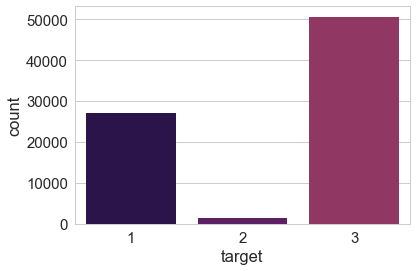

In [142]:
sns.countplot(df['target'])

In [143]:
X = df.drop(['target'], axis = 1)

y = df['target']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1210)

In [145]:
# A function that will give us R-squared value, Classification Report and Top 10 Features

def score(model, test = X_test, y_true = y_test):
    
    pred = model.predict(test)

    print("R-Squared Score:\t",round(r2_score(y_true,pred),4)*100)
    print()
    print(classification_report(y_true,pred))
    print()
    feat_imp = pd.DataFrame(model.feature_importances_,index=X.columns,columns=['Feature Importance'])
    top_feat = feat_imp.sort_values('Feature Importance',ascending=False).index[0:10]
    print("Top 10 Features:\n",top_feat)

### Decision Tree Classifier

In [146]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [147]:
score(dtree)

R-Squared Score:	 33.28

              precision    recall  f1-score   support

           1       0.77      0.79      0.78      8144
           2       0.85      0.80      0.83       425
           3       0.89      0.88      0.88     15157

   micro avg       0.85      0.85      0.85     23726
   macro avg       0.84      0.82      0.83     23726
weighted avg       0.85      0.85      0.85     23726


Top 10 Features:
 Index(['origIntRate', 'adjustedMonthsToMaturity', 'loanAge',
       'borrowerCreditScoreAtOrigination', 'currActualUPB', 'orgLTV',
       'zipCodeShort', 'orgDebttoIncomeRatio', 'currIntRate', 'numBorrowers'],
      dtype='object')


### Random Forest Classifier

In [148]:
rf = RandomForestClassifier(n_estimators=100)

In [149]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
score(rf)

R-Squared Score:	 55.08

              precision    recall  f1-score   support

           1       0.90      0.79      0.84      8144
           2       0.82      0.80      0.81       425
           3       0.89      0.96      0.92     15157

   micro avg       0.89      0.89      0.89     23726
   macro avg       0.87      0.85      0.86     23726
weighted avg       0.89      0.89      0.89     23726


Top 10 Features:
 Index(['origIntRate', 'adjustedMonthsToMaturity', 'currIntRate', 'loanAge',
       'borrowerCreditScoreAtOrigination', 'remainingMonthsToLegalMaturity',
       'orgDebttoIncomeRatio', 'orgLTV', 'currActualUPB', 'orgCombinedLTV'],
      dtype='object')


### LightGBM Classifier

In [78]:
lgbm = LGBMClassifier(n_estimators=1000)

In [79]:
lgbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [151]:
score(lgbm)

R-Squared Score:	 61.45

              precision    recall  f1-score   support

           1       0.91      0.82      0.87      8144
           2       0.94      0.92      0.93       425
           3       0.91      0.96      0.93     15157

   micro avg       0.91      0.91      0.91     23726
   macro avg       0.92      0.90      0.91     23726
weighted avg       0.91      0.91      0.91     23726


Top 10 Features:
 Index(['loanAge', 'borrowerCreditScoreAtOrigination', 'currActualUPB',
       'loanID', 'remainingMonthsToLegalMaturity', 'orgUPB', 'zipCodeShort',
       'adjustedMonthsToMaturity', 'orgDebttoIncomeRatio', 'origIntRate'],
      dtype='object')


### LightGBM Classifier After Parameter Tuning using GridSearch

In [105]:
params = {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 9),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}

In [106]:
gs = GridSearchCV(lgbm,param_grid=params, scoring = 'f1_weighted', n_jobs=12, verbose=1)

In [107]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 43.3min
[Parallel(n_jobs=12)]: Done 768 out of 768 | elapsed: 80.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'num_leaves': (24, 45), 'feature_fraction': (0.1, 0.9), 'bagging_fraction': (0.8, 1), 'max_depth': (5, 9), 'lambda_l1': (0, 5), 'lambda_l2': (0, 3), 'min_split_gain': (0.001, 0.1), 'min_child_weight': (5, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=1)

In [152]:
score(gs.best_estimator_)

R-Squared Score:	 62.39

              precision    recall  f1-score   support

           1       0.91      0.83      0.87      8144
           2       0.93      0.93      0.93       425
           3       0.91      0.96      0.94     15157

   micro avg       0.91      0.91      0.91     23726
   macro avg       0.92      0.91      0.91     23726
weighted avg       0.91      0.91      0.91     23726


Top 10 Features:
 Index(['currActualUPB', 'loanAge', 'orgUPB',
       'borrowerCreditScoreAtOrigination', 'remainingMonthsToLegalMaturity',
       'zipCodeShort', 'loanID', 'origIntRate', 'orgDebttoIncomeRatio', 'msa'],
      dtype='object')


# Results

After comparing various predictive models on a subset of data (Under Sampled Data), we were able to achieve:

### High Risk Loans
**93% Precision and 96% Recall**

### Moderate Risk Loans
**93% Precision and 93% Recall**

### No Risk Loans
**91% Precision and 83% Recall**


We wanted to use **Area Under ROC and Area Under PRC** as metrics but they are not suitable for multiclass classification problems and due to limited time we used **F1-Score** which is a weighted score of PRECISION and RECALL.